In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import random

## Загрузить транзакции

In [80]:
# some_clients = [29815, 51978]

transactions_file = "../hackathon_data/avk_hackathon_data_transactions.csv"
useful_cols = ['party_rk', 'transaction_dttm', 'transaction_amt_rur', 'merchant_group_rk', 'category']
transactions = pd.read_csv(transactions_file, usecols=useful_cols, parse_dates=['transaction_dttm'])
# transactions = transactions.loc[transactions['party_rk'].isin(some_clients)]
print(transactions.shape)
transactions.head()

(11987617, 5)


,party_rk,transaction_dttm,transaction_amt_rur,merchant_group_rk,category
0,20337,2019-01-01,84.00,NaN,Сувениры
1,63404,2019-01-01,410.00,725.0,Фаст Фуд
2,24789,2019-01-01,701.44,NaN,Супермаркеты
3,57970,2019-01-01,6203.70,454.0,Дом/Ремонт
4,12232,2019-01-01,734.53,878.0,Супермаркеты


## Загрузить данные о возрасте

In [81]:
socdem_file = "../hackathon_data/avk_hackathon_data_party_x_socdem.csv"
useful_cols = ['party_rk', 'age']
socdem = pd.read_csv(socdem_file, usecols=useful_cols)
# socdem = socdem.loc[socdem['party_rk'].isin(some_clients)]
print(socdem.shape)
socdem.head()

(50000, 2)


,party_rk,age
0,61243,70.0
1,66535,25.0
2,83721,55.0
3,88238,35.0
4,57179,30.0


## Объединить таблицы и выбрать людей в возрасте 60+

In [82]:
df = pd.merge(transactions, socdem, on='party_rk').dropna(subset=['merchant_group_rk'])
df.drop(df[df.age < 60].index, inplace=True)
df.drop(columns='age', inplace=True)
print(df.shape)
df.head()

(344202, 5)


,party_rk,transaction_dttm,transaction_amt_rur,merchant_group_rk,category
19767,29815,2019-01-01,757.03,341.0,Супермаркеты
19775,29815,2019-01-01,314.00,341.0,Супермаркеты
19779,29815,2019-01-10,1470.61,341.0,Супермаркеты
19784,29815,2019-01-15,53.90,878.0,Супермаркеты
19792,29815,2019-01-17,251.00,589.0,Связь/Телеком


## Просуммировать затраты за месяц для каждой сети магазинов

In [91]:
monthly = pd.Grouper(key='transaction_dttm',freq='M')
df_monthly = df.groupby([monthly, 'party_rk', 'merchant_group_rk', 'category']).agg({'transaction_amt_rur': 'sum'})
df_monthly.rename(columns={'transaction_amt_rur': 'monthly_amt'}, inplace=True)
print(df_monthly.shape)
df_monthly.head()

(133367, 1)


monthly_amt
transaction_dttm party_rk merchant_group_rk category                      
2019-01-31       8        205.0             Красота                3935.00
                 30       243.0             Финансовые услуги      5100.00
                          999.0             Супермаркеты            520.25
                          1211.0            Аптеки                 1257.00
                          2259.0            Финансовые услуги        11.00

## Найти средние месячные затраты для каждой сети магазинов

In [92]:
df_monthly = df_monthly.groupby(['party_rk', 'merchant_group_rk', 'category']).agg({'monthly_amt': 'mean'})
df_monthly.rename(columns={'monthly_amt': 'avg_monthly_amt'}, inplace=True)
df_monthly.reset_index(inplace=True)
print(df_monthly.shape)
df_monthly.head()

(53577, 4)


,party_rk,merchant_group_rk,category,avg_monthly_amt
0,8,100.0,Разные товары,311.0
1,8,113.0,Дом/Ремонт,69.0
2,8,205.0,Красота,3935.0
3,8,341.0,Супермаркеты,466.0
4,8,610.0,Супермаркеты,324.0


## Average monthly overall spendings

In [99]:
df_monthly_overall = df_monthly.groupby(['party_rk']).agg({'avg_monthly_amt': 'sum'})
df_monthly_overall.rename(columns={'avg_monthly_amt': 'avg_monthly_amt_overall'}, inplace=True)
print(df_monthly_overall.shape)
df_monthly_overall.head()

(4141, 1)


,avg_monthly_amt_overall
party_rk,
8,7737.000000
11,13734.318333
15,248213.125833
30,9244.237143
32,30722.851667


## Proportion of money spent on each merchant group

In [101]:
df_monthly_portion = pd.merge(df_monthly, df_monthly_overall, on='party_rk')
df_monthly_portion['portion'] = df_monthly_portion.avg_monthly_amt / df_monthly_portion.avg_monthly_amt_overall
df_monthly_portion.drop(columns=['avg_monthly_amt', 'avg_monthly_amt_overall'], inplace=True)
print(df_monthly_portion.shape)
df_monthly_portion.head()

(53577, 4)


,party_rk,merchant_group_rk,category,portion
0,8,100.0,Разные товары,0.040196
1,8,113.0,Дом/Ремонт,0.008918
2,8,205.0,Красота,0.508595
3,8,341.0,Супермаркеты,0.060230
4,8,610.0,Супермаркеты,0.041877


### Check that sum of portions equals 1

In [107]:
portion_check = df_monthly_portion.groupby(['party_rk']).agg({'portion': 'sum'})
n_rows = portion_check.shape[0]
n_ones = portion_check.loc[(portion_check.portion - 1).abs() < eps].shape[0]
assert n_rows == n_ones

## Renumber client IDs and merchant group IDs

In [108]:
print(f"Min client ID: {df_monthly_portion.party_rk.values.min()},", \
      f"max client ID: {df_monthly_portion.party_rk.values.max()}")
df_monthly_portion.party_rk = df_monthly_portion.party_rk.rank(method='dense').astype(int) - 1
print(f"Min client ID after renumbering: {df_monthly_portion.party_rk.values.min()},", \
      f"max client ID after renumbering: {df_monthly_portion.party_rk.values.max()}")

print(f"\nMin merchant group ID: {df_monthly_portion.merchant_group_rk.values.min()},", \
      f"max merchant group ID: {df_monthly_portion.merchant_group_rk.values.max()}")
df_monthly_portion.merchant_group_rk = df_monthly_portion.merchant_group_rk.rank(method='dense').astype(int) - 1
print(f"Min merchant group ID after renumbering: {df_monthly_portion.merchant_group_rk.values.min()},", \
      f"max merchant group ID after renumbering: {df_monthly_portion.merchant_group_rk.values.max()}")

Min client ID: 8, max client ID: 94521
Min client ID after renumbering: 0, max client ID after renumbering: 4140

Min merchant group ID: 3.0, max merchant group ID: 2957.0
Min merchant group ID after renumbering: 0, max merchant group ID after renumbering: 1774


In [110]:
data_matrix = spsp.csr_matrix((df_monthly_portion.portion.values, 
                              (df_monthly_portion.party_rk.values, df_monthly_portion.merchant_group_rk.values)))
print(data_matrix.shape)

(4141, 1775)


In [111]:
rank = 100
_, S, Vt = spsplin.svds(data_matrix, k=rank, return_singular_vectors='vh')

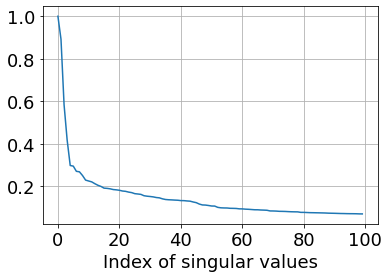

In [112]:
plt.plot(S[::-1] / S[-1])
plt.xlabel("Index of singular values", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(True)

In [145]:
nb_favourites = 5
nb_nonzero = 20
client_id = random.randint(0, data_matrix.shape[0] - 1)
client_spendings = data_matrix[client_id].toarray()[0]
while (client_spendings > 0).sum() < nb_nonzero:
    client_id = random.randint(0, data_matrix.shape[0] - 1)
    client_spendings = data_matrix[client_id].toarray()[0]
top_spendings = np.argsort(-client_spendings)[:nb_favourites]
print(f"Client #{client_id} on average spends most on the following merchants:")
for merchant in top_spendings:
    print(f"    merchant {merchant} -- {client_spendings[merchant]*100}% of monthly spendings")

Client #1507 on average spends most on the following merchants:
    merchant 227 -- 29.277831610396454% of monthly spendings
    merchant 1616 -- 11.110200486231285% of monthly spendings
    merchant 13 -- 10.614902693288101% of monthly spendings
    merchant 551 -- 8.42708118236039% of monthly spendings
    merchant 407 -- 7.4021254781195704% of monthly spendings


In [146]:
nb_recommends = 5
correlation = Vt.T @ Vt[:, top_spendings]
score = correlation.sum(axis=1)
# score = correlation @ client_spendings[top_spendings]
top_merchants = np.argsort(-score)
recommendations = []
for rec in top_merchants:
    print(rec)
    if rec not in top_spendings:
        recommendations.append(rec)
        print("Recommend")
    if len(recommendations) == nb_recommends:
        break
print("How many are successfull?", (client_spendings[recommendations] > 0).sum())

1616
551
254
Recommend
902
Recommend
156
Recommend
400
Recommend
569
Recommend
How many are successfull? 1
